In [3]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import yfinance as yf
import vectorbt as vbt
from datetime import datetime, timedelta

In [2]:
data = pd.DataFrame()
data = data.ta.ticker(
     "AAPL",
     start=datetime(2021, 3, 1),
     end=datetime(2021, 3, 15),
     interval='1h'
)
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2021-03-01 09:30:00-05:00,123.500000,125.250000,122.790001,125.084999,30763287,0,0
2021-03-01 10:30:00-05:00,125.084999,126.154999,124.880096,125.879898,15870701,0,0
2021-03-01 11:30:00-05:00,125.879997,126.620003,125.789902,126.230003,13509856,0,0
2021-03-01 12:30:00-05:00,126.239998,126.400002,125.669998,126.209297,8484702,0,0
2021-03-01 13:30:00-05:00,126.205002,127.230003,126.089996,127.105003,11084566,0,0
...,...,...,...,...,...,...,...
2021-03-12 12:30:00-05:00,120.849800,121.070000,120.427002,120.896698,8122057,0,0
2021-03-12 13:30:00-05:00,120.889999,121.010002,120.500000,120.589996,6602156,0,0
2021-03-12 14:30:00-05:00,120.595001,120.900002,120.464996,120.754997,7340616,0,0
2021-03-12 15:30:00-05:00,120.760002,121.169998,120.680000,121.040100,7978422,0,0


In [259]:
orders = pd.DataFrame({
        'price_action': [10, 10, 10, 10, 10],
        'entries': [True, False, True, False, False],
        'exits': [False, True, False, False, True],
        'lots': [2, 0, 5, np.nan, 0] # 0 is close order, np.nan is skip
    }
    ,index=[datetime(2022, 1, 1) + timedelta(days=i) for i in range(5)])
orders

,price_action,entries,exits,lots
2022-01-01,10,True,False,2.0
2022-01-02,10,False,True,0.0
2022-01-03,10,True,False,5.0
2022-01-04,10,False,False,NaN
2022-01-05,10,False,True,0.0


In [260]:
port = vbt.Portfolio.from_signals(orders.price_action,
                                  entries=orders.entries,
                                  exits=orders.exits,
                                  size=orders.lots,
                                  freq="D",
                                  init_cash=100,
                                  fees=0.0025, 
                                  slippage=0.0025
                                 )

In [261]:
port.plot().show()

<AxesSubplot:>

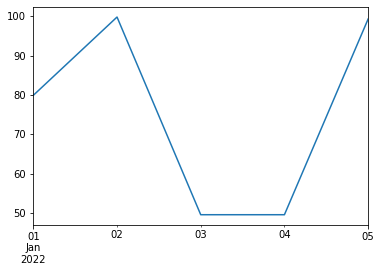

In [262]:
port.cash().plot()

In [263]:
port.stats()

Start                         2022-01-01 00:00:00
End                           2022-01-05 00:00:00
Period                            5 days 00:00:00
Start Value                                 100.0
End Value                                    99.3
Total Return [%]                             -0.7
Benchmark Return [%]                          0.0
Max Gross Exposure [%]                  50.226175
Total Fees Paid                              0.35
Max Drawdown [%]                         0.600476
Max Drawdown Duration             4 days 00:00:00
Total Trades                                    2
Total Closed Trades                             2
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                  0.0
Best Trade [%]                          -0.997506
Worst Trade [%]                         -0.997506
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                    -0.997506


In [276]:
# Fees = Size * Price * fees , This Fees for lot size
# Avg Entry Price = price_action + (price_action * Slippage)
# Avg Exit Price = price_action - (price_action * Slippage)

port.orders.records_readable

,Order Id,Column,Timestamp,Size,Price,Fees,Side
0,0,0,2022-01-01,2.0,10.025,0.050125,Buy
1,1,0,2022-01-02,2.0,9.975,0.049875,Sell
2,2,0,2022-01-03,5.0,10.025,0.125312,Buy
3,3,0,2022-01-05,5.0,9.975,0.124688,Sell


In [265]:
2*10.025*0.0025

0.050125

In [277]:
# Size = Lot size
# Cash entry side = Cash - (size * Avg Entry Price + Entry Fees)
# Cash exit side = Cash + (size * Avg Exit Price - Exit Fees)
# Cash order entry side = (size * Price) + (Size * Price * fees) = size * (Price + (Price * fees)) = size * (Price * (1+fees))
# Cash order exit side = (size * Price) - (Size * Price * fees) = size * (Price - (Price * fees)) = size * (Price * (1-fees))
# size = taget entry cash / (Price * (1 + fees))

port.trades.records_readable

,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,0,2.0,2022-01-01,10.025,0.050125,2022-01-02,9.975,0.049875,-0.2,-0.009975,Long,Closed,0
1,1,0,5.0,2022-01-03,10.025,0.125312,2022-01-05,9.975,0.124688,-0.5,-0.009975,Long,Closed,1


In [267]:
79.699875 + (9.975*2 - 0.049875)

99.60000000000001

In [268]:
port.cash()

2022-01-01    79.899875
2022-01-02    99.800000
2022-01-03    49.549688
2022-01-04    49.549688
2022-01-05    99.300000
dtype: float64

In [271]:
stats = port.stats()
print(stats['Win Rate [%]'])
print(stats['Avg Losing Trade [%]'])

0.0
-0.9975062344139369
